# Divide a long 1cycle policy into smaller ones

In [6]:
from fastai.callbacks.one_cycle import OneCycleScheduler

import numpy as np
import matplotlib.pyplot as plt

from mock import *
from partial_one_cycle_scheduler import PartialOneCycleScheduler

For this experiment, let's set: 

In [3]:
data_size = 100
lr_max = 0.1
cycle_len = 6

Where `data_size` is the number of batches for fake train data loader, `lr_max` is the max learning rate in the 1cycle policy, `cycle_len` is the number of epochs to train in the 1cycle policy. Since the learning rate is changed at the end of every batch, we'll have 600 learning rate plot points with these settings. 

In this notebook, we only care about how the learning rates and momentums are scheduled during training, so I have a `LearnerMock` to simulate the training process. It only contains the code where the 1cycle policy callback is called during training.

Let's fit our fake learner with the `OneCycleScheduler` and plot the learning rates and momentums:

In [9]:
learn = LearnerMock(data_size)

In [10]:
ocs = OneCycleScheduler(learn, lr_max)

In [11]:
learn.fit(cycle_len, callbacks=[ocs])

Epoch: 100%|██████████| 6/6 [00:00<00:00, 997.34it/s]


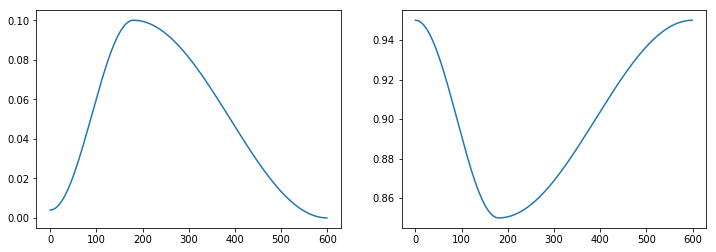

In [12]:
learn.recorder.plot_lr(True)

The `OneCycleScheduler` uses two cosine phases. The above plots show that our mockup training process works fine. 

Now we want to divide this big cycle into smaller steps. We'd like to be able to run part of the above 1cycle policy, e.g., just train from epoch 2 to epoch 4. So we need to know which epoch to start, and how many epochs the big cycle has. For example, if the start epoch is 2, the big cycle contains 6 epochs, then if we train for 2 epochs, then we end up training epoch 2 ~ 4 in the 6 epoch 1cycle policy. 

We can use the learning rate scheduler of the original `OneCycleScheduler`, but let it run until the start epoch, before the training begins.

In [ ]:
class PartialOneCycleScheduler(OneCycleScheduler):
    def __init__(self, learn:Learner, lr_max:float,                  
                 moms:Floats=(0.95,0.85), 
                 div_factor:float=25., pct_start:float=0.3,
                 tot_epochs:int=-1, start_epoch:int=0):
        super().__init__(learn, lr_max, moms, div_factor, pct_start)
        self.start_epoch = start_epoch        
        self.tot_epochs = tot_epochs
            
    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None:
        if self.tot_epochs < 0: self.tot_epochs = n_epochs + self.start_epoch        
        super().on_train_begin(self.tot_epochs, **kwargs)
                      
        self.start_iter = len(self.learn.data.train_dl) * self.start_epoch                
        for _ in range(self.start_iter):
            super().on_batch_end(True)               

Let's test how it works. We divide the big 1cycle policy into 3 parts, and run `fit` for all of them:

In [7]:
n_steps = 3
start = 0
epochs_per_step = cycle_len // n_steps
lrs = []
moms = []
for i in range(n_steps):
    end = start + epochs_per_step
    
    learn_ = LearnerMock(data_size)
    ocsr = PartialOneCycleScheduler(learn_, lr_max, 
                                    tot_epochs=cycle_len, start_epoch=start)
    learn_.fit(end-start, callbacks=[ocsr])
    lrs.append(learn_.recorder.lrs)
    moms.append(learn_.recorder.moms)
    start = end

Epoch: 100%|██████████| 2/2 [00:00<00:00, 399.91it/s]


Now we plot the learning rates and momentums:

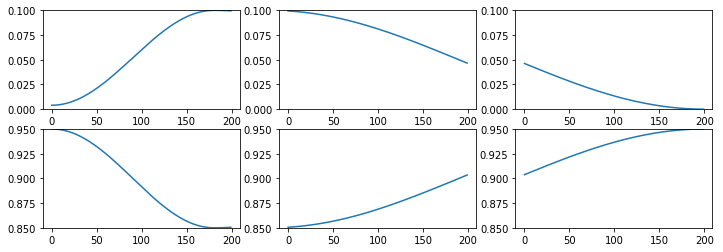

In [8]:
_, axs = plt.subplots(2, 3, figsize=(12,4))
for i in range(n_steps):
    axs[0,i].plot(lrs[i])
    axs[0,i].set_ylim([0, lr_max])
    axs[1,i].plot(moms[i])
    axs[1,i].set_ylim([0.85,0.95])

The first row is the learning rates, the second row is the momentums. It looks right, but let's compare every single values with those from our big 1cycle policy: 

In [13]:
iters_per_step = epochs_per_step*data_size
for i in range(n_steps):
    print(f'{i+1}. lr matches:', learn.recorder.lrs[i*iters_per_step:(i+1)*iters_per_step] == lrs[i])
    print('   mom matches:', learn.recorder.moms[i*iters_per_step:(i+1)*iters_per_step] == moms[i])

1. lr matches: True
   mom matches: True
2. lr matches: True
   mom matches: True
3. lr matches: True
   mom matches: True


All of them are consistent. 